In [1]:
# 5. (a) Mounting and Data Preparation
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# from google.colab import drive
from tensorflow.keras.regularizers import l2

In [2]:
# 5. (b) Hyperparameter Setup and Data Preparation
epochs = 300
batch_size = 32
training_samples = 4000
validation_samples = 600
img_width = 152
img_height = 152
channels = 3
test_samples = 200
input_shape = (img_width, img_height, channels)

In [3]:
train_data_dir = "Small_set_cats_vs_dogs/Small_set_cats_vs_dogs/train"
val_data_dir = "Small_set_cats_vs_dogs/Small_set_cats_vs_dogs/val"

train_datagen = ImageDataGenerator(
    rescale = 1. /255, shear_range = 0.4, zoom_range = 0.4, rotation_range = 40, width_shift_range = 0.4,
    height_shift_range = 0.4, horizontal_flip = True, vertical_flip = True, fill_mode = 'nearest'    
)

val_datagen = ImageDataGenerator(
    rescale = 1. / 255
)

train_generator = train_datagen.flow_from_directory(
    train_data_dir, target_size = (img_width, img_height), batch_size = batch_size, class_mode = 'binary'
)

validation_generator = val_datagen.flow_from_directory(
    val_data_dir, target_size = (img_width, img_height), batch_size = batch_size, class_mode ='binary'
)

Found 4000 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [4]:
# 5. (c) Model Setup
# First Approach
vgg_lite_model = Sequential([
    Conv2D(input_shape = input_shape, filters = 32, kernel_size = (3, 3), padding = 'same', 
           activation = 'relu', kernel_initializer = 'he_uniform', kernel_regularizer = l2(l = 0.01)),
    Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation = 'relu', 
           kernel_initializer = 'he_uniform', kernel_regularizer = l2(l = 0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2, 2), strides = 2),

    Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu',
           kernel_initializer = 'he_uniform', kernel_regularizer = l2(l = 0.01)),
    Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu',
           kernel_initializer = 'he_uniform', kernel_regularizer = l2(l = 0.01)),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2, 2), strides = 2),

    Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation = 'relu',
           kernel_initializer = 'he_uniform', kernel_regularizer = l2(l = 0.01)),
    Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation = 'relu',
           kernel_initializer = 'he_uniform', kernel_regularizer = l2(l = 0.01)),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2, 2), strides = 2),

    Conv2D(filters = 256, kernel_size = (3, 3), padding = 'same', activation = 'relu',
           kernel_initializer = 'he_uniform', kernel_regularizer = l2(l = 0.01)),
    Conv2D(filters = 256, kernel_size = (3, 3), padding = 'same', activation = 'relu',
           kernel_initializer = 'he_uniform', kernel_regularizer = l2(l = 0.01)),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2, 2), strides = 2),
    
    Conv2D(filters = 256, kernel_size = (3, 3), padding = 'same', activation = 'relu',
           kernel_initializer = 'he_uniform', kernel_regularizer = l2(l = 0.01)),
    Conv2D(filters = 256, kernel_size = (3, 3), padding = 'same', activation = 'relu',
           kernel_initializer = 'he_uniform', kernel_regularizer = l2(l = 0.01)),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2, 2), strides = 2),

    Flatten(),
    Dense(units = 1024, activation = 'relu', kernel_initializer = 'he_uniform'),
    Dense(units = 512, activation = 'relu', kernel_initializer = 'he_uniform'),
    Dropout(0.5),
    Dense(units = 1, activation = 'sigmoid')
])

In [7]:
vgg_lite_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 152, 152, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 152, 152, 32)      9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 152, 152, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 76, 76, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 76, 76, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 76, 76, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 76, 76, 64)        2

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(vgg_lite_model, to_file='vgg_lite_model.png', show_shapes=True, show_layer_names=True)

In [5]:
# 5. (d) Model Training
optimizer = SGD(learning_rate = 0.001, momentum = 0.9)
#optimizer = RMSprop(learning_rate = 0.0001)
vgg_lite_model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 5, verbose = 0,
                              mode = 'auto', min_delta = 0.0001, cooldown = 0, min_lr = 0)
snapshot_name = 'vgg_lite_model'
checkpoint = ModelCheckpoint(filepath = snapshot_name + ".{epoch:02d}-{val_accuracy:.2f}.h5",
                             monitor = 'val_accuracy', verbose = 0, save_best_only = True,
                             save_weights_only = True, mode = 'auto')

In [6]:
history = vgg_lite_model.fit(train_generator, steps_per_epoch = training_samples // batch_size,
                                  epochs = epochs, validation_data = validation_generator, 
                                  validation_steps = validation_samples // batch_size,
                                  callbacks = [reduce_lr, checkpoint])

Epoch 1/300
125/125 [==============================] - 85s 636ms/step - loss: 29.6610 - accuracy: 0.5389 - val_loss: 28.6501 - val_accuracy: 0.4983
Epoch 2/300
125/125 [==============================] - 68s 546ms/step - loss: 28.0195 - accuracy: 0.5484 - val_loss: 27.0484 - val_accuracy: 0.4878
Epoch 3/300
125/125 [==============================] - 69s 547ms/step - loss: 26.6577 - accuracy: 0.5692 - val_loss: 25.6942 - val_accuracy: 0.5434
Epoch 4/300
125/125 [==============================] - 66s 525ms/step - loss: 25.3767 - accuracy: 0.5724 - val_loss: 24.4450 - val_accuracy: 0.6024
Epoch 5/300
125/125 [==============================] - 63s 505ms/step - loss: 24.1638 - accuracy: 0.5880 - val_loss: 23.3154 - val_accuracy: 0.5382
Epoch 6/300
125/125 [==============================] - 69s 555ms/step - loss: 23.0115 - accuracy: 0.5991 - val_loss: 22.1853 - val_accuracy: 0.5903
Epoch 7/300
125/125 [==============================] - 85s 683ms/step - loss: 21.9324 - accuracy: 0.5961 - val_l

125/125 [==============================] - 70s 562ms/step - loss: 2.4440 - accuracy: 0.7569 - val_loss: 2.5314 - val_accuracy: 0.6615
Epoch 57/300
125/125 [==============================] - 70s 563ms/step - loss: 2.3733 - accuracy: 0.7271 - val_loss: 2.2403 - val_accuracy: 0.8021
Epoch 58/300
125/125 [==============================] - 70s 560ms/step - loss: 2.2631 - accuracy: 0.7563 - val_loss: 2.2682 - val_accuracy: 0.7413
Epoch 59/300
125/125 [==============================] - 70s 561ms/step - loss: 2.1930 - accuracy: 0.7498 - val_loss: 2.1044 - val_accuracy: 0.7778
Epoch 60/300
125/125 [==============================] - 70s 561ms/step - loss: 2.1083 - accuracy: 0.7603 - val_loss: 2.0598 - val_accuracy: 0.7517
Epoch 61/300
125/125 [==============================] - 70s 559ms/step - loss: 2.0354 - accuracy: 0.7585 - val_loss: 2.0371 - val_accuracy: 0.7292
Epoch 62/300
125/125 [==============================] - 70s 562ms/step - loss: 1.9635 - accuracy: 0.7646 - val_loss: 1.9348 - val_a

Epoch 112/300
125/125 [==============================] - 70s 558ms/step - loss: 0.6103 - accuracy: 0.8725 - val_loss: 0.5090 - val_accuracy: 0.9201
Epoch 113/300
125/125 [==============================] - 70s 561ms/step - loss: 0.6002 - accuracy: 0.8868 - val_loss: 0.5783 - val_accuracy: 0.8993
Epoch 114/300
125/125 [==============================] - 70s 559ms/step - loss: 0.5993 - accuracy: 0.8794 - val_loss: 0.5067 - val_accuracy: 0.9271
Epoch 115/300
125/125 [==============================] - 70s 559ms/step - loss: 0.5818 - accuracy: 0.8909 - val_loss: 0.5222 - val_accuracy: 0.9184
Epoch 116/300
125/125 [==============================] - 70s 559ms/step - loss: 0.5969 - accuracy: 0.8763 - val_loss: 0.5316 - val_accuracy: 0.9028
Epoch 117/300
125/125 [==============================] - 70s 560ms/step - loss: 0.6032 - accuracy: 0.8731 - val_loss: 0.5073 - val_accuracy: 0.9028
Epoch 118/300
125/125 [==============================] - 70s 557ms/step - loss: 0.5890 - accuracy: 0.8867 - val_

125/125 [==============================] - 51s 406ms/step - loss: 0.5629 - accuracy: 0.8833 - val_loss: 0.4979 - val_accuracy: 0.9236
Epoch 168/300
125/125 [==============================] - 54s 430ms/step - loss: 0.5516 - accuracy: 0.8972 - val_loss: 0.4917 - val_accuracy: 0.9271
Epoch 169/300
125/125 [==============================] - 53s 422ms/step - loss: 0.5454 - accuracy: 0.9017 - val_loss: 0.4951 - val_accuracy: 0.9271
Epoch 170/300
125/125 [==============================] - 50s 396ms/step - loss: 0.5535 - accuracy: 0.8963 - val_loss: 0.4874 - val_accuracy: 0.9271
Epoch 171/300
125/125 [==============================] - 47s 377ms/step - loss: 0.5540 - accuracy: 0.8964 - val_loss: 0.4997 - val_accuracy: 0.9253
Epoch 172/300
125/125 [==============================] - 45s 357ms/step - loss: 0.5667 - accuracy: 0.8888 - val_loss: 0.5022 - val_accuracy: 0.9219
Epoch 173/300
125/125 [==============================] - 52s 414ms/step - loss: 0.5471 - accuracy: 0.8967 - val_loss: 0.4993 -

125/125 [==============================] - 27s 214ms/step - loss: 0.5482 - accuracy: 0.8995 - val_loss: 0.4982 - val_accuracy: 0.9236
Epoch 223/300
125/125 [==============================] - 29s 233ms/step - loss: 0.5554 - accuracy: 0.9004 - val_loss: 0.4951 - val_accuracy: 0.9271
Epoch 224/300
125/125 [==============================] - 32s 256ms/step - loss: 0.5527 - accuracy: 0.8994 - val_loss: 0.5029 - val_accuracy: 0.9219
Epoch 225/300
125/125 [==============================] - 34s 272ms/step - loss: 0.5550 - accuracy: 0.8906 - val_loss: 0.4961 - val_accuracy: 0.9253
Epoch 226/300
125/125 [==============================] - 30s 240ms/step - loss: 0.5263 - accuracy: 0.9125 - val_loss: 0.5006 - val_accuracy: 0.9219
Epoch 227/300
125/125 [==============================] - 31s 244ms/step - loss: 0.5506 - accuracy: 0.9021 - val_loss: 0.4981 - val_accuracy: 0.9236
Epoch 228/300
125/125 [==============================] - 38s 301ms/step - loss: 0.5582 - accuracy: 0.8924 - val_loss: 0.4977 -

125/125 [==============================] - 27s 215ms/step - loss: 0.5679 - accuracy: 0.8875 - val_loss: 0.4975 - val_accuracy: 0.9253
Epoch 278/300
125/125 [==============================] - 26s 208ms/step - loss: 0.5583 - accuracy: 0.8965 - val_loss: 0.4929 - val_accuracy: 0.9236
Epoch 279/300
125/125 [==============================] - 26s 209ms/step - loss: 0.5351 - accuracy: 0.9085 - val_loss: 0.4982 - val_accuracy: 0.9219
Epoch 280/300
125/125 [==============================] - 26s 209ms/step - loss: 0.5425 - accuracy: 0.8990 - val_loss: 0.5024 - val_accuracy: 0.9219
Epoch 281/300
125/125 [==============================] - 26s 208ms/step - loss: 0.5488 - accuracy: 0.9030 - val_loss: 0.5013 - val_accuracy: 0.9236
Epoch 282/300
125/125 [==============================] - 31s 249ms/step - loss: 0.5371 - accuracy: 0.9081 - val_loss: 0.5010 - val_accuracy: 0.9253
Epoch 283/300
125/125 [==============================] - 31s 246ms/step - loss: 0.5479 - accuracy: 0.9043 - val_loss: 0.4975 -

In [ ]:
# Second Approach
img_width = 224
img_height = 224
input_shape = (img_width, img_height)

vgg_lite_model_approach_2 = Sequential([
    Conv2D(input_shape = input_shape, filters = 32, kernel_size = (2, 2), padding = 'same', 
           activation = 'relu', kernel_initializer = 'he_uniform', kernel_regularizer = l2(l = 0.01)),
    Conv2D(filters = 32, kernel_size = (2, 2), padding = 'same', activation = 'relu', 
           kernel_initializer = 'he_uniform', kernel_regularizer = l2(l = 0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2, 2), strides = 2),

    Conv2D(filters = 32, kernel_size = (2, 2), padding = 'same', activation = 'relu', 
           kernel_initializer = 'he_uniform', kernel_regularizer = l2(l = 0.01)),
    Conv2D(filters = 32, kernel_size = (2, 2), padding = 'same', activation = 'relu',
           kernel_initializer = 'he_uniform', kernel_regularizer = l2(l = 0.01)),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2, 2), strides = 2),

    Conv2D(filters = 64, kernel_size = (2, 2), padding = 'same', activation = 'relu',
           kernel_initializer = 'he_uniform', kernel_regularizer = l2(l = 0.01)),
    Conv2D(filters = 64, kernel_size = (2, 2), padding = 'same', activation = 'relu',
           kernel_initializer = 'he_uniform', kernel_regularizer = l2(l = 0.01)),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2, 2), strides = 2),

    Conv2D(filters = 64, kernel_size = (2, 2), padding = 'same', activation = 'relu',
           kernel_initializer = 'he_uniform', kernel_regularizer = l2(l = 0.01)),
    Conv2D(filters = 64, kernel_size = (2, 2), padding = 'same', activation = 'relu',
           kernel_initializer = 'he_uniform', kernel_regularizer = l2(l = 0.01)),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2, 2), strides = 2),

    Conv2D(filters = 128, kernel_size = (2, 2), padding = 'same', activation = 'relu',
           kernel_initializer = 'he_uniform', kernel_regularizer = l2(l = 0.01)),
    Conv2D(filters = 128, kernel_size = (2, 2), padding = 'same', activation = 'relu',
           kernel_initializer = 'he_uniform', kernel_regularizer = l2(l = 0.01)),
    Conv2D(filters = 128, kernel_size = (2, 2), padding = 'same', activation = 'relu',
           kernel_initializer = 'he_uniform', kernel_regularizer = l2(l = 0.01)),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2, 2), strides = 2),
    
    Conv2D(filters = 128, kernel_size = (2, 2), padding = 'same', activation = 'relu',
           kernel_initializer = 'he_uniform', kernel_regularizer = l2(l = 0.01)),
    Conv2D(filters = 128, kernel_size = (2, 2), padding = 'same', activation = 'relu',
           kernel_initializer = 'he_uniform', kernel_regularizer = l2(l = 0.01)),
    Conv2D(filters = 128, kernel_size = (2, 2), padding = 'same', activation = 'relu',
           kernel_initializer = 'he_uniform', kernel_regularizer = l2(l = 0.01)),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2, 2), strides = 2),

    Flatten(),
    Dense(units = 1024, activation = 'relu', kernel_initializer = 'he_uniform'),
    Dense(units = 1024, activation = 'relu', kernel_initializer = 'he_uniform'),
    Dense(units = 256, activation = 'relu', kernel_initializer = 'he_uniform'),
    Dense(units = 1, activation = 'sigmoid')
])

In [ ]:
vgg_lite_model_approach_2

In [ ]:
plot_model(vgg_lite_model_approach_2, to_file='vgg_lite_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
optimizer = SGD(learning_rate = 0.001, momentum = 0.9)
#optimizer = RMSprop(learning_rate = 0.0001)
vgg_lite_model_approach_2.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 5, verbose = 0,
                              mode = 'auto', min_delta = 0.0001, cooldown = 0, min_lr = 0)
snapshot_name = 'vgg_lite_model_approach_2'
checkpoint = ModelCheckpoint(filepath = snapshot_name + ".{epoch:02d}-{val_accuracy:.2f}.h5",
                             monitor = 'val_accuracy', verbose = 0, save_best_only = True,
                             save_weights_only = True, mode = 'auto')

history = vgg_lite_model_approach_2.fit(train_generator, steps_per_epoch = training_samples // batch_size,
                                  epochs = epochs, validation_data = validation_generator, 
                                  validation_steps = validation_samples // batch_size,
                                  callbacks = [reduce_lr, checkpoint])

In [9]:
# 5. (e)
# Model_vgg evaluation
test_data_dir = "Small_set_cats_vs_dogs/Small_set_cats_vs_dogs/test"

test_datagen = ImageDataGenerator(
    rescale = 1. /255
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'binary'
)

Found 200 images belonging to 2 classes.


In [10]:
vgg_lite_model.evaluate_generator(test_generator, verbose = 2)

c:\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


7/7 - 5s - loss: 0.5335 - accuracy: 0.9150


[0.5335274338722229, 0.9150000214576721]

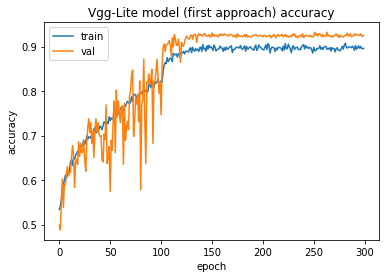

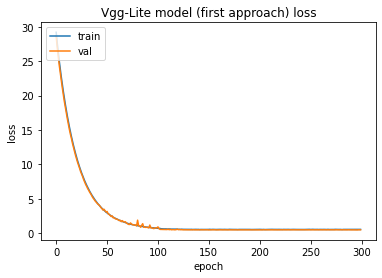

In [8]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Vgg-Lite model (first approach) accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Vgg-Lite model (first approach) loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# 5.(h)
# AlexNet
model_alex = Sequential([
    Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [ ]:
model_alex.summary()

In [ ]:
plot_model(model_alex, to_file='vgg_lite_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Alexnet
optimizer = SGD(learning_rate = 0.001, momentum = 0.9)
#optimizer = RMSprop(learning_rate = 0.0001)
model_alex.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 5, verbose = 2,
                              mode = 'auto', min_delta = 0.0001, cooldown = 0, min_lr = 0)
snapshot_name = 'alex_image_model'
checkpoint = ModelCheckpoint(filepath = snapshot_name + ".{epoch:02d}-{val_accuracy:.2f}.h5",
                             monitor = 'val_accuracy', verbose = 0, save_best_only = True,
                             save_weights_only = True, mode = 'auto')

In [ ]:
history = model_alex.fit(train_generator, steps_per_epoch = training_samples // batch_size,
                                  epochs = epochs, validation_data = validation_generator, 
                                  validation_steps = validation_samples // batch_size,
                                  callbacks = [reduce_lr, checkpoint])

model_alex.save_weights('model_alex_final.h5')

In [ ]:
model_alex.evaluate_generator(test_generator, verbose = 2)

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('AlexNet-Lite model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('AlexNet-Lite model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Saving model
model_json = model.to_json()  # Input right name of the model
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
# Loading model and weights
from tensorflow.keras.models import model_from_json

json_file = open("model.json", "r") # Input right name of the model
loaded_model_json = json_file.read()
json_file.close()

loaded_vgg_model = model_from_json(loaded_model_json)
loaded_vgg_model.load_weights ("Weight.h5")  # Input right name of the weight
print("Model load complete")